In [10]:
import stability_functions as sf
import numpy as np
import sys
import rebound
import corner
import pandas as pd
import dask.dataframe as dd
from multiprocessing import Pool
# plotting
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('paper.mplstyle')
# %matplotlib inline
import os

# Generating systems and scores

In [2]:
systems = ["HR858", "K431", "TOI270", "L98-59"]
system = systems[0]
sf.valid_system(system)
sim_names = system + "/" + system
n = 100
n_workers = os.cpu_count()

In [3]:
def pred(nsim):
    return sf.pred(sim_names, nsim)

def get_k(row):
    return sf.get_k(sim_names, row)

pool = Pool(processes=n_workers, initializer=sf.init_process)

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.21.3. Th

In [4]:
# %%time
mb, mc, md = sf.draw_masses(system, int(3e3))

In [5]:
# %%time
for i in range(n):
    name = sim_names + "_sa_%d.bin"%i
    sf.replace_snapshot(sf.build_forecasted_system(system, mb, mc, md), name)

In [6]:
# %%time
nsim_list = np.arange(0, n)
res = pool.map(pred, nsim_list)

In [7]:
# %%time
df1 = sf.add_k_cols(pd.DataFrame(nsim_list, columns=['sim']))
df1['probstability'] = res

dasklabels = dd.from_pandas(df1, npartitions=n_workers)
df = dasklabels.apply(get_k, axis=1, meta=df1).compute(scheduler='processes')

df["m1"] *= sf.earth_mass_p_solar_mass
df["m2"] *= sf.earth_mass_p_solar_mass
df["m3"] *= sf.earth_mass_p_solar_mass
df["m1+m2"] = df["m1"] + df["m2"]
df["m2+m3"] = df["m2"] + df["m3"]
df["total m"] = df["m1"] + df["m2"] + df["m3"]

df.to_csv(sim_names + ".csv")

/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/storage/home/cjg66/miniconda3/lib/python3.7/site-packages/rebound/simulationarchive.py:132: RuntimeWarning: You have to reset function pointers after creating a reb_simulation struct with a binary file.
  warnings.warn(message, RuntimeWarning)
/storage/home/cjg66/

In [8]:
# import rebound

# nsim = 1
# sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%nsim)[0]
# print([sim.particles[i].r for i in range(4)])
# rebound.OrbitPlot(sim)
# sim.integrate(0.001)
# rebound.OrbitPlot(sim)


# sys.path.append("../spock")
# from spock import StabilityClassifier
# model = StabilityClassifier()
    
# def pred(nsim):
#     sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%nsim)[0]
#     sim.move_to_com()
#     sim.integrator="whfast"
#     sim.dt = 0.07*sim.particles[1].P
# #     prob=model.predict(sim)
#     prob=model.predict(sim, copy=False)
#     return prob

# pred(nsim)


# Corner plots

In [13]:
df = pd.read_csv(sim_names + ".csv", index_col=0)
scores = 2 * df["probstability"]
n = len(scores)
# effective sample size using eq 9.13 https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf
effective_sample_size = n * np.mean(scores) ** 2 / np.mean(scores ** 2)
print(effective_sample_size)
print(n)
print(effective_sample_size / n)

3342.508372166147
10000
0.3342508372166147


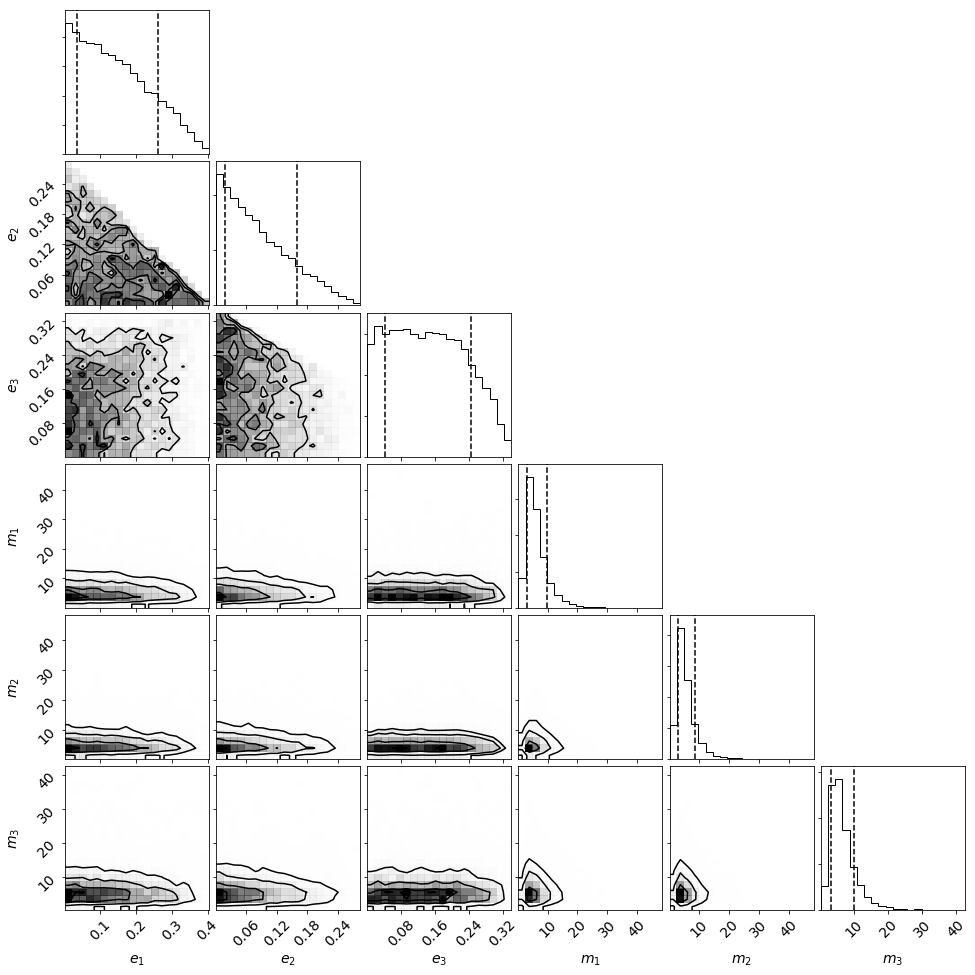

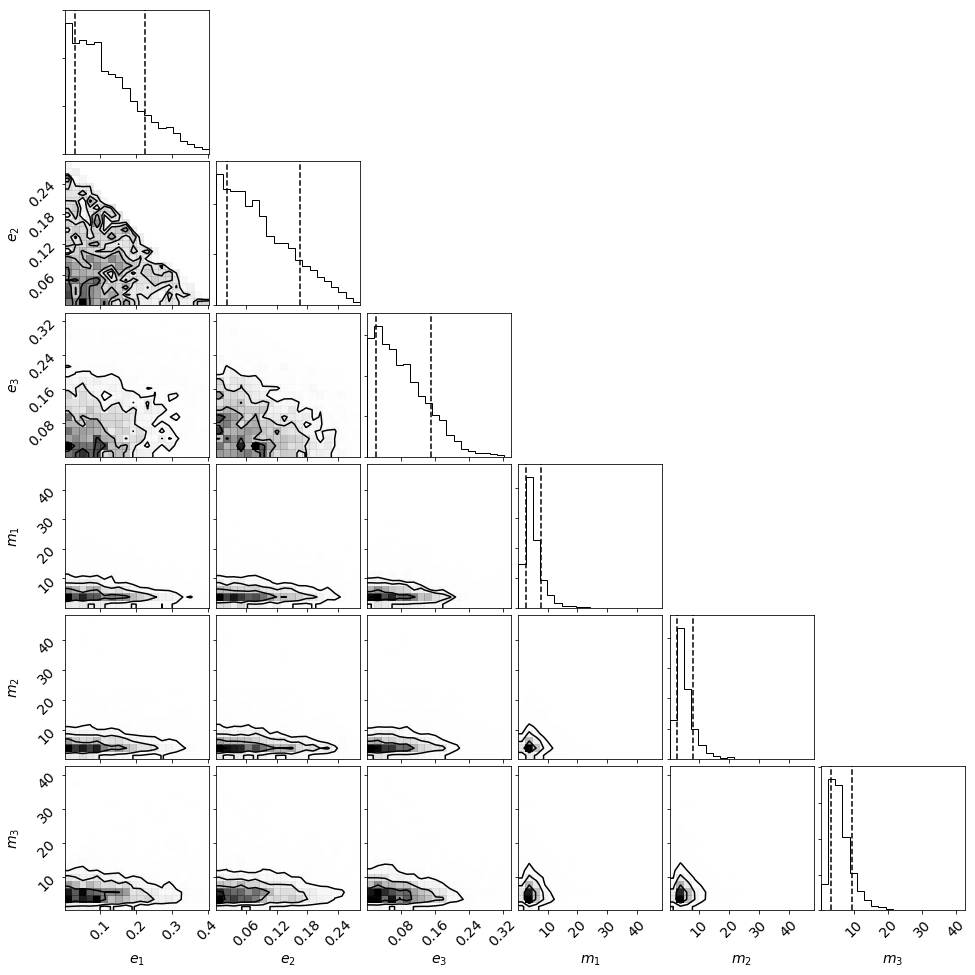

In [14]:
labels = ["e1","e2", "e3", "m1", "m2", "m3"]
labels2 = [r"$e_1$", r"$e_2$", r"$e_3$", r"$m_1$", r"$m_2$", r"$m_3$"]
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False)
plt.savefig("figs/" + system + "_physical_corner_noweight.png", bbox_inches="tight")
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.savefig("figs/" + system + "_physical_corner_weight.png", bbox_inches="tight")

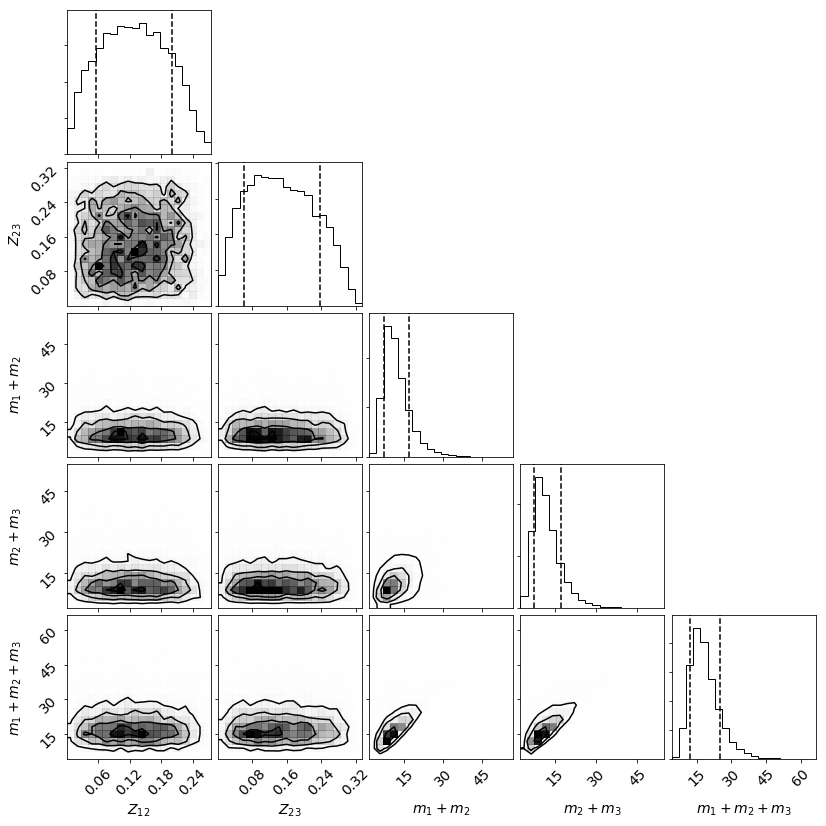

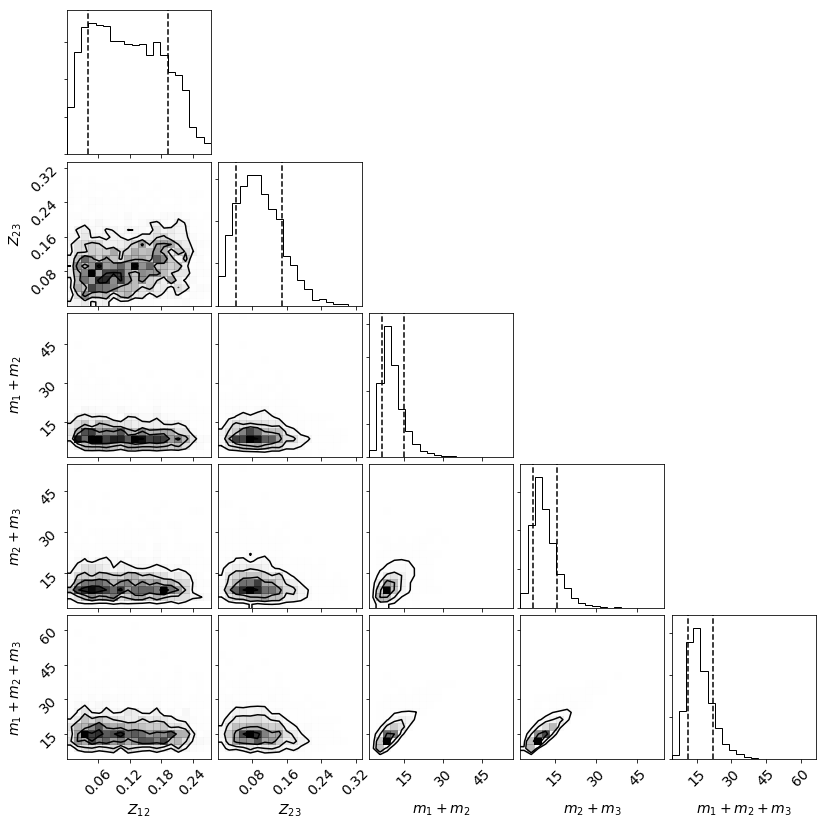

In [15]:
labels = ["Z12", "Z23", "m1+m2", "m2+m3", "total m"]
labels2 = [r"$Z_{12}$", r"$Z_{23}$", r"$m_1 + m_2$", r"$m_2 + m_3$", r"$m_1 + m_2 + m_3$"]
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False)
plt.savefig("figs/" + system + "_param_corner_noweight.png", bbox_inches="tight")
fig = corner.corner(df[labels], labels=labels2, quantiles=[0.15,0.85], plot_datapoints=False, weights=df["probstability"])
plt.savefig("figs/" + system + "_param_corner_weight.png", bbox_inches="tight")

"sigma" before: 3.169542
"sigma" after: 2.493771
factor of 1.270984 smaller
"sigma" before: 2.713241
"sigma" after: 2.559338
factor of 1.060134 smaller
"sigma" before: 3.289640
"sigma" after: 2.951647
factor of 1.114510 smaller


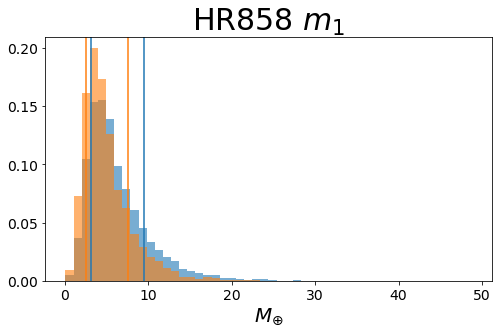

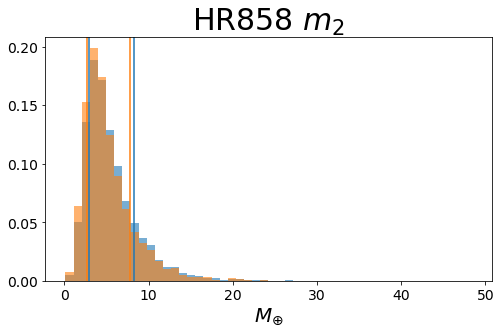

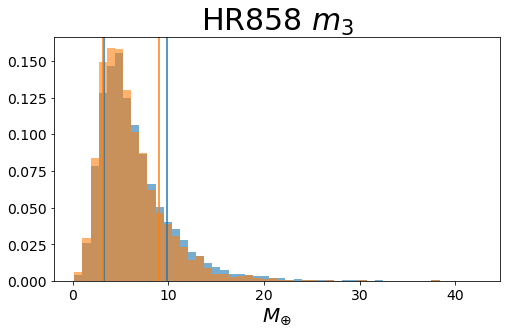

In [16]:
sf.create_stab_hist(system, df, "m1", label2=r"$m_1$", xlabel=r"$M_{\oplus}$")
sf.create_stab_hist(system, df, "m2", label2=r"$m_2$", xlabel=r"$M_{\oplus}$")
sf.create_stab_hist(system, df, "m3", label2=r"$m_3$", xlabel=r"$M_{\oplus}$")

"sigma" before: 4.580844
"sigma" after: 3.954480
factor of 1.158394 smaller
"sigma" before: 4.613632
"sigma" after: 4.285328
factor of 1.076611 smaller
"sigma" before: 6.003550
"sigma" after: 5.197300
factor of 1.155129 smaller


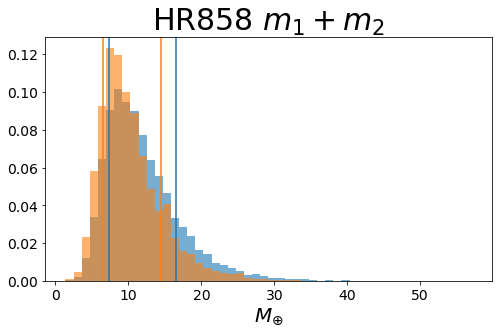

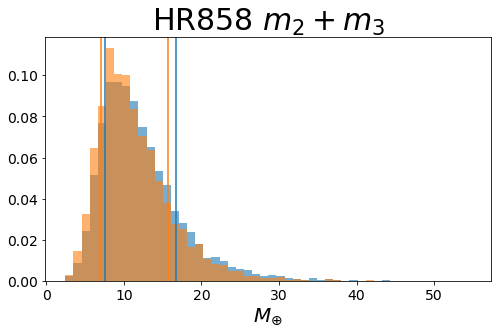

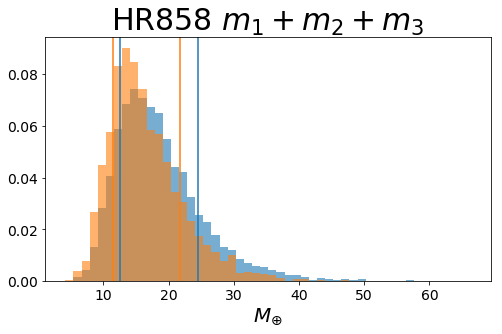

In [17]:
sf.create_stab_hist(system, df, "m1+m2", label2=r"$m_1 + m_2$", xlabel=r"$M_{\oplus}$")
sf.create_stab_hist(system, df, "m2+m3", label2=r"$m_2 + m_3$", xlabel=r"$M_{\oplus}$")
sf.create_stab_hist(system, df, "total m", label2=r"$m_1 + m_2 + m_3$", xlabel=r"$M_{\oplus}$")

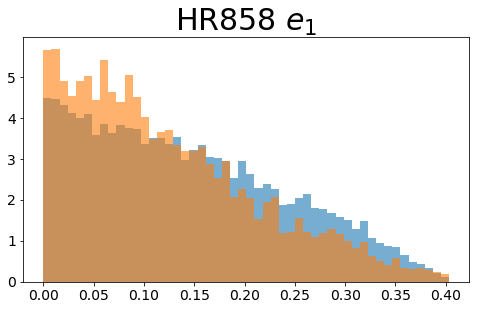

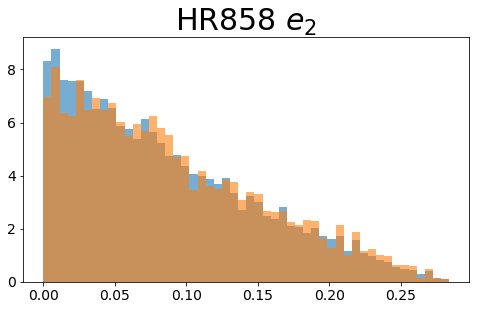

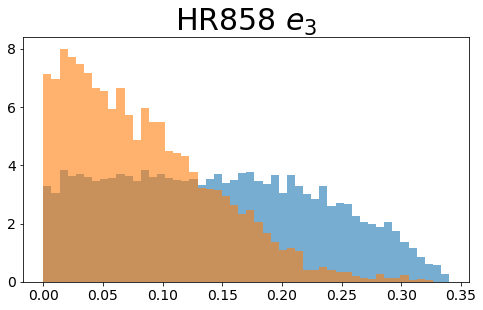

In [18]:
sf.create_stab_hist(system, df, "e1", show_quantiles=False, label2=r"$e_1$")
sf.create_stab_hist(system, df, "e2", show_quantiles=False, label2=r"$e_2$")
sf.create_stab_hist(system, df, "e3", show_quantiles=False, label2=r"$e_3$")

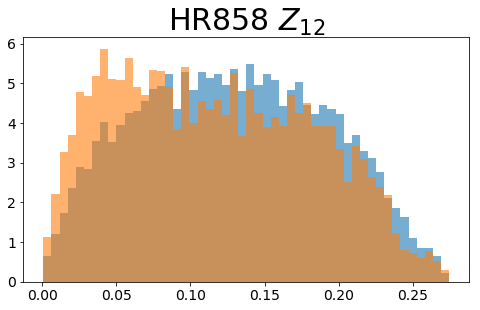

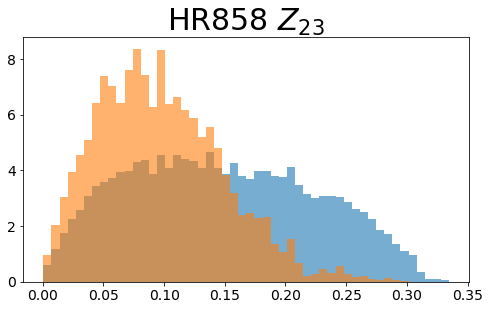

In [19]:
sf.create_stab_hist(system, df, "Z12", show_quantiles=False, label2=r"$Z_{12}$")
sf.create_stab_hist(system, df, "Z23", show_quantiles=False, label2=r"$Z_{23}$")

In [ ]:
import numpy as np
import pandas as pd
import sys
import rebound

def collision(reb_sim, col):
    reb_sim.contents._status = 5
    return 0

if len(sys.argv) > 3:
    shadow = bool(int(sys.argv[3]))
else:
    shadow = False

systems = ["HR858", "K431", "TOI270", "L98-59"]
system = systems[int(sys.argv[1])]
sim_names = system + "/" + system

df = pd.read_csv(sim_names + ".csv", index_col=0)
df = df.sort_values("probstability", ascending=False)
nsim = int(df.iloc[int(sys.argv[2])]["sim"])

sim = rebound.SimulationArchive(sim_names + "_sa_%d.bin"%nsim)[0]

if shadow:
    df2 = pd.read_csv(sim_names + "_%d_orbits.csv"%nsim, index_col=0)
    if not df2["stable"][0]:
        sys.exit("not worth running a shadow system for dummy thin system")
    else:
        sim.particles[2].x *= 1 + 1.e-11
        
P1 = sim.particles[1].P
try:
    sim.integrate(1e9 * P1, exact_finish_time=0)
    orbits = sim.t / P1
    res = True
except:
    orbits = sim.t / P1
    res = False

if shadow:
    df2["orbits_shadow"] = orbits
    df2["stable_shadow"] = res
else:
    df2 = pd.DataFrame(data=[nsim], columns=["sim"])
    df2["orbits"] = orbits
    df2["stable"] = res
df2.to_csv(sim_names + "_%d_orbits.csv"%nsim)